In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [3]:
# Transform to 3 channels and resize images to 224x224 (ResNet input size)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load FashionMNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [4]:
# Load pre-trained ResNet model
model = resnet18(pretrained=True)
model.eval()  # Set to evaluation mode

# Remove the classifier (fc layers) to get features from the last conv layer
feature_extractor = nn.Sequential(*list(model.children())[:-1])

def extract_features(loader, model):
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in tqdm(loader):
            outputs = model(images)
            features.append(outputs.view(outputs.size(0), -1).cpu().numpy())
            labels.append(targets.cpu().numpy())
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels

train_features, train_labels = extract_features(train_loader, feature_extractor)
test_features, test_labels = extract_features(test_loader, feature_extractor)



/Users/swathibaskaran/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/swathibaskaran/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|█████████████████████████████████████████| 157/157 [03:12<00:00,  1.22s/it]


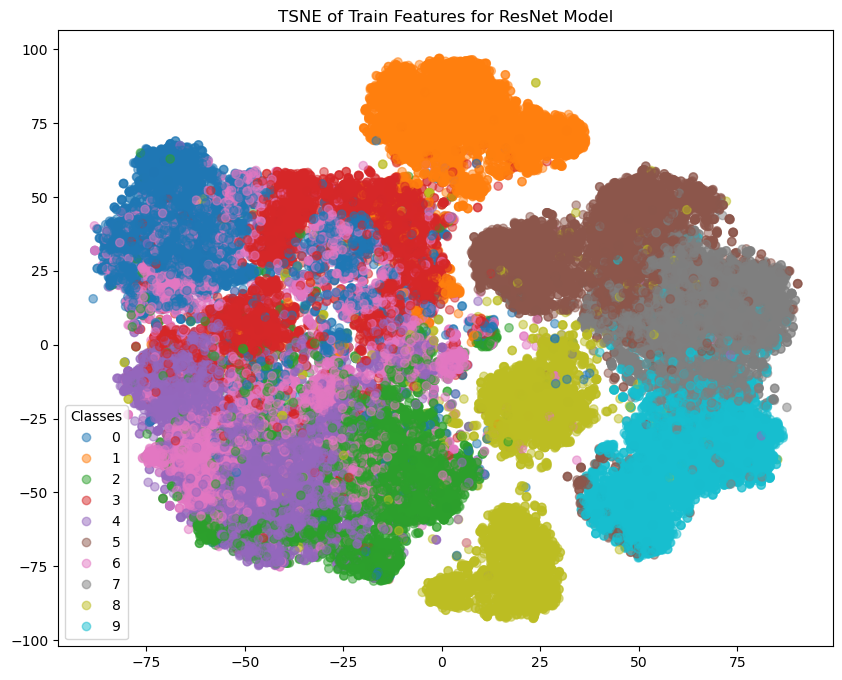

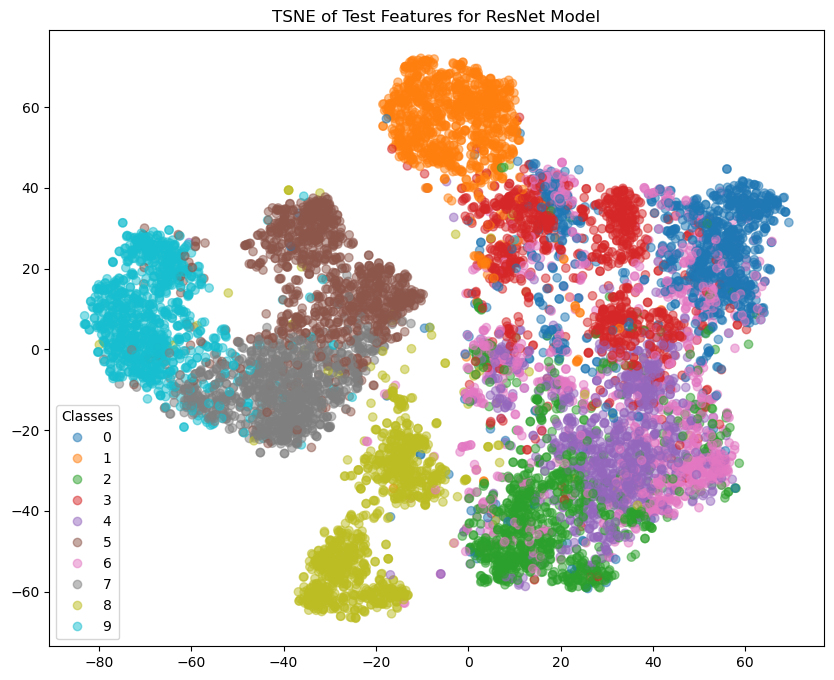

In [18]:
def calculate_tsne(features):
    tsne = TSNE(n_components=2, random_state=0)
    tsne_result = tsne.fit_transform(features)
    return tsne_result

train_tsne = calculate_tsne(train_features)
test_tsne = calculate_tsne(test_features)

def plot_tsne(tsne_result, labels, title):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='tab10', alpha=0.5)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title(title)
    plt.show()

plot_tsne(train_tsne, train_labels, "TSNE of Train Features for ResNet Model")
plot_tsne(test_tsne, test_labels, "TSNE of Test Features for ResNet Model")


In [15]:
import itertools

def calculate_intra_class_variance(tsne_result, labels):
    classes = np.unique(labels)
    intra_class_variances = {}
    for cls in classes:
        class_tsne = tsne_result[labels == cls]
        variance = np.var(class_tsne, axis=0).mean()
        intra_class_variances[cls] = variance
    return intra_class_variances

def calculate_inter_class_variance(tsne_result, labels, subset_size=10):
    classes = np.unique(labels)
    pairs = list(itertools.combinations(classes, 2))
    inter_class_variances = []
    for pair in pairs[:subset_size]:  # Limit to a subset if there are too many pairs
        combined_tsne = tsne_result[(labels == pair[0]) | (labels == pair[1])]
        variance = np.var(combined_tsne, axis=0).mean()
        inter_class_variances.append((pair, variance))
    return inter_class_variances

train_intra_class_variances = calculate_intra_class_variance(train_tsne, train_labels)
test_intra_class_variances = calculate_intra_class_variance(test_tsne, test_labels)
train_inter_class_variances = calculate_inter_class_variance(train_tsne, train_labels)
test_inter_class_variances = calculate_inter_class_variance(test_tsne, test_labels)

print("Intra-class Variances for Training Set:")
for cls, variance in train_intra_class_variances.items():
    print(f"Class {cls}: {variance:.3f}")

print("Intra-class Variances for Test Set:")
for cls, variance in test_intra_class_variances.items():
    print(f"Class {cls}: {variance:.3f}")


Intra-class Variances for Training Set:
Class 0: 453.983
Class 1: 214.494
Class 2: 388.850
Class 3: 424.731
Class 4: 401.174
Class 5: 287.407
Class 6: 754.865
Class 7: 166.507
Class 8: 575.319
Class 9: 204.719
Intra-class Variances for Test Set:
Class 0: 292.235
Class 1: 114.587
Class 2: 231.755
Class 3: 227.353
Class 4: 171.047
Class 5: 118.399
Class 6: 501.118
Class 7: 84.634
Class 8: 223.437
Class 9: 101.578


In [16]:
print("Inter-class Variances for Training Set (pairwise):")
for pair, variance in train_inter_class_variances:
    print(f"Class pair {pair}: {variance:.3f}")

print("Inter-class Variances for Test Set (pairwise):")
for pair, variance in test_inter_class_variances:
    print(f"Class pair {pair}: {variance:.3f}")

Inter-class Variances for Training Set (pairwise):
Class pair (0, 1): 992.556
Class pair (0, 2): 1328.456
Class pair (0, 3): 530.535
Class pair (0, 4): 1010.479
Class pair (0, 5): 1493.629
Class pair (0, 6): 856.782
Class pair (0, 7): 2263.672
Class pair (0, 8): 2033.266
Class pair (0, 9): 2686.361
Class pair (1, 2): 2034.485
Inter-class Variances for Test Set (pairwise):
Class pair (0, 1): 637.086
Class pair (0, 2): 802.285
Class pair (0, 3): 319.053
Class pair (0, 4): 509.479
Class pair (0, 5): 932.506
Class pair (0, 6): 528.126
Class pair (0, 7): 1254.444
Class pair (0, 8): 1302.119
Class pair (0, 9): 1844.348
Class pair (1, 2): 1309.717


In [17]:
def calculate_inter_class_variance(tsne_result, labels, class_pairs):
    inter_class_variances = []
    for pair in class_pairs:
        combined_tsne = tsne_result[(labels == pair[0]) | (labels == pair[1])]
        variance = np.var(combined_tsne, axis=0).mean()
        inter_class_variances.append((pair, variance))
    return inter_class_variances

# Specify the class pairs to compare
class_pairs_to_compare = [(2, 6)]

# Assuming train_tsne and test_tsne are the t-SNE results and train_labels and test_labels are the labels
train_inter_class_variances = calculate_inter_class_variance(train_tsne, train_labels, class_pairs_to_compare)
test_inter_class_variances = calculate_inter_class_variance(test_tsne, test_labels, class_pairs_to_compare)

print("Inter-class Variances for Training Set:")
for pair, variance in train_inter_class_variances:
    print(f"Class pair {pair}: {variance:.3f}")

print("Inter-class Variances for Test Set:")
for pair, variance in test_inter_class_variances:
    print(f"Class pair {pair}: {variance:.3f}")



Inter-class Variances for Training Set:
Class pair (2, 6): 780.220
Inter-class Variances for Test Set:
Class pair (2, 6): 505.205
